<div style="background-color:red;">
<img src="https://lh3.googleusercontent.com/XXM3-Pn9u24Z4o0sTMvBAFVLiZeGGy5qHH7knJNmD1RS2jEr7m2bR7Zb7wjWbw6rloX9YQEJsd4HZj6XO9v1B3BtzAzHdFvRygRcAHGa5Fp3WFEiQkgbVVGfnn_JhhIhyqwwHToxhG47rF_VVx8hNuL3T09RDabP_CGIh6zsDvn6dM4zCAFpBNM0UrGsBg7r0526fVoWyaythMTRPJSv15X4YOpSmXBUCczAL2V5MH-TmRRbcqScREugbYWutjkAQuKtvqDFLFRIeHPQ5dqa185huPKlG4Ocu2XRzUhwrowHy5dbUbZDExDgTsAE1xzkk5EcHHauLPEEsvybobnVMNwqEBMUUZRze6VutdABNEma8aCuanbPqqSC3p3-ZhV5GTT30FepB9_biW58eD8MavckKeXoJk860Xarj10FoxUkUJMn6nufAQu0KkvRNBrAffEQYC5jd2Mhs54JD7w843YUsOZdi2dYtn5kKAFFBLlDCYrrnoL0hSe4RKNI2EyeGEVwxHlITKJFqWR_11ES_gO2pZ4st3MFmcWZ4VT2VER9vDZ1vXJXrAVsbfeGohTcmsrgfelrceS-76wa34z_o838Q-KyCtrkqeu36Gfv-ZbO0ZvheouDSWXmWMT4x3OjhIRaJm6j5h7B3r_CpnvXWDr9KvR_ens=w1280-h268-no" >
</div>

In [0]:
import math
import pickle
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import TensorBoard


##**Signature Verification**
The objective of signature verification systems is to discriminate if a given signature is genuine or a forgery.

Depending on the acquisition method, signature verification systems are divided in two categories: online (dynamic) and offline (static).


*   **Online:** An acquisition device, such as a digitizing table, is used to acquire the user's signature. The data is collected as a sequence over time, containing the position of the pen, and in some cases including additional information such as the as the pen inclination, pressure, etc. 
*   **Offline:**The signature is acquired after the writing process is completed. In this case, the signature is represented as a digital image.

The dataset used in this project is made up of a set of 120 signatures, 60 of them genuine and 60 forged.
This signatures are represented as PNG images.





In [0]:
with open('./dataset_owner.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [3]:
#@title Dataset information { vertical-output: true, form-width: "50%" }
X_train, X_test, Y_train, Y_test = train_test_split(
    dataset['data'], 
    dataset['label'], 
    test_size=0.33, 
    shuffle=True
)
print(
  "Train images:",len(X_train)
)
print(
  "Test images:", len(X_test)
)

Train images: 80
Test images: 40


We normalize the signatures by making a resize of 256*256

[]

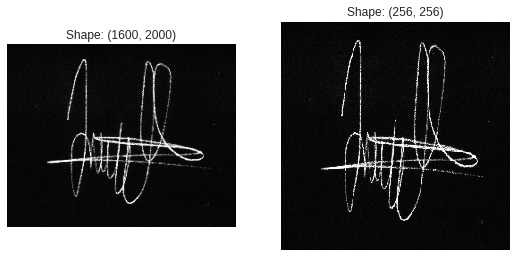

In [4]:
#@title Preprocessed data { vertical-output: true, form-width: "50%" }

i = 1
img = X_train[i]


fig, axs = plt.subplots(ncols=2, figsize=(9,5))

axs[0].imshow(cv.resize(img, (2000, 1600)))
axs[0].set_title('Shape: (1600, 2000)')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(img)
axs[1].set_title('Shape: (256, 256)')
axs[1].set_xticks([])
axs[1].set_yticks([])



In [0]:
# Hyperparameters
learning_rate = 0.001
num_steps = 100
batch_size = 20
display_step = 2

In [0]:
# Network Parameters
num_classes = len(np.unique(dataset['label'])) # multiclass classification
dropout = 0.5 # Dropout, probability to keep units

In [0]:
# Placeholders
X = tf.placeholder(tf.float32, [None, 256, 256], name = 'image_input')
Y = tf.placeholder(tf.float32, [None, num_classes], name = 'image_label')
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [8]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 64*64*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([64*64*64, 1024])),
    # 1024 inputs, 2 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def one_hot_encode(vec, vals=num_classes):
    '''
    For use to one-hot encode the num_classes - possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

class dataset():
    
    def __init__(self):
        self.i = 0
        
        self.training_images = X_train
        self.training_labels = one_hot_encode(Y_train)
        
        self.test_images = X_test
        self.test_labels = one_hot_encode(Y_test)
        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        
        return x, y

## CNN Architecture
In neural networks, Convolutional neural network (ConvNets or CNNs) is one of the main categories to do images recognition, images classifications. Objects detections, recognition faces etc., are some of the areas where CNNs are widely used.
![CNN](https://lh3.googleusercontent.com/ou35CiTMbveAXdFjj93nTwXW5KqeVldQwhxXnEBb24xfq6tEK0jI79dP_CZ7Vuv_8bgodJp_KGsIxa9WfrzKYo6QLtD4Y_8kxcfKJyYklJlDBfQQB70v8IUQ4tHMBAKeTHpQcoAvjap5IIjRn-FK2YlIZ154Oj_6X4O62DK3Zq1cey-Vyu_2Jdr-kPn4o84GcJkA6nzbThh45lXQvVQ4pjtTXqmq4tygqALrYMHBLORZ9mz25TaCcbSuwoDsc569VhQCo8yAYbZAoPI2_36OyGnaL-vFcKBHDuJ-muoiwlF6FSN73z2DGdMVWOXUIlsxKshqs5_k9rSiLbNU2_-qey0R0ic93yl3IIoppRaHSKUMlafv5PICOSLx2aou3vAvt-YH6RP0kET2g9cqQdEp7zn5ggZS6Jaqb5o5TBm-xncH7IZgzxzUyrcb2RfF8-1cd4PGMtTfWv6NTGzG9JUnITpdedimKqGIxdZgohEWc2eruBNmCt9ndumccPMbamY0d78Pqs50EG1JxojNB3nAS8Gl2DENuyc7CTZVHrw8uU2iJPu5WvRHkolk-kpKbXDRbXFep6TDnzJQj0nmY5GwJAM1qHN43wa1-g2MToiM7JwX1ZcECZ8tv8yCdJa9Pz_kKiJDr7hSmRyoodGWJ6z-6ClnrnKRWCvHbWEJilTsdLAlWG2CNDIGID-zVnBLDjcadLowMdtVtPD2kainuqX4R_83=w994-h856-no)

In [0]:
# Operations
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [0]:
# Create model
def conv_net(x, weights, biases, dropout):
    # Keep reshape in case the image is flatten
    x = tf.reshape(x, shape=[-1, 256, 256, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [12]:
# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [0]:
init = tf.global_variables_initializer()

In [16]:
#@title Training ...{ vertical-output: true, form-width: "50%" }
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
predList = []

#Create dataset object
data = dataset()

# Start training
with tf.Session() as sess:
    writer = tf.summary.FileWriter('./logs', sess.graph)
    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        batch_x, batch_y = data.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            loss_t, acc_t = sess.run([loss_op, accuracy], feed_dict={X: data.test_images,
                                      Y: data.test_labels,
                                      keep_prob: 1.0})
            train_losses.append(loss)
            train_accuracies.append(acc)
            
            test_losses.append(loss_t)
            test_accuracies.append(acc_t)
            
            print(
                "Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc) + ", Testing Accuracy= " + \
                  "{:.3f}".format(acc_t)
            )
            


    print("Optimization Finished!")

    # Calculate accuracy 
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: data.test_images,
                                      Y: data.test_labels,
                                      keep_prob: 1.0}))
    
    a = sess.run(correct_pred, feed_dict={X: data.test_images,
                                      Y: data.test_labels,
                                      keep_prob: 1.0})
    writer.close()
    
    predList.append(a)
    malClasificados = np.where(predList[0] == False)[0]

Step 1, Minibatch Loss= 192863584.0000, Training Accuracy= 0.600, Testing Accuracy= 0.500
Step 2, Minibatch Loss= 215156384.0000, Training Accuracy= 0.400, Testing Accuracy= 0.500
Step 4, Minibatch Loss= 4639186.5000, Training Accuracy= 0.750, Testing Accuracy= 0.650
Step 6, Minibatch Loss= 184157744.0000, Training Accuracy= 0.600, Testing Accuracy= 0.500
Step 8, Minibatch Loss= 90999968.0000, Training Accuracy= 0.600, Testing Accuracy= 0.500
Step 10, Minibatch Loss= 66594168.0000, Training Accuracy= 0.400, Testing Accuracy= 0.500
Step 12, Minibatch Loss= 89662568.0000, Training Accuracy= 0.400, Testing Accuracy= 0.500
Step 14, Minibatch Loss= 45243676.0000, Training Accuracy= 0.600, Testing Accuracy= 0.500
Step 16, Minibatch Loss= 27262812.0000, Training Accuracy= 0.600, Testing Accuracy= 0.500
Step 18, Minibatch Loss= 11257324.0000, Training Accuracy= 0.600, Testing Accuracy= 0.750
Step 20, Minibatch Loss= 28778820.0000, Training Accuracy= 0.550, Testing Accuracy= 0.525
Step 22, Mini

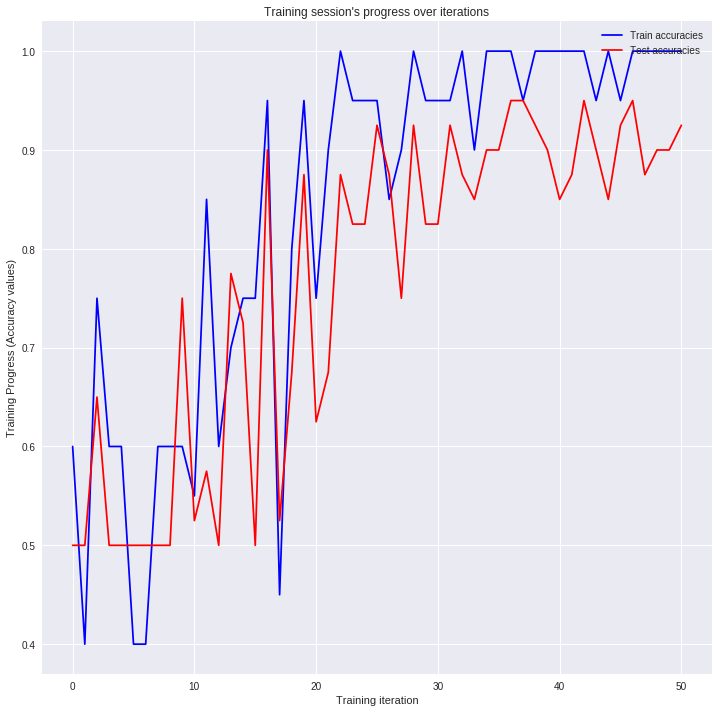

In [17]:
#@title Accuracy while training { vertical-output: true, form-width: "50%" }
width = 12
height = 12
plt.figure(figsize=(width, height))

# indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
# plt.plot(np.array(train_losses),     "b--", label="Train losses")
plt.plot(np.array(train_accuracies), "b", label="Train accuracies")

# indep_test_axis = np.append(
#     np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
#     [training_iters]
# )
# plt.plot(np.array(test_losses),     "r--", label="Test losses")
plt.plot(np.array(test_accuracies), "r", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

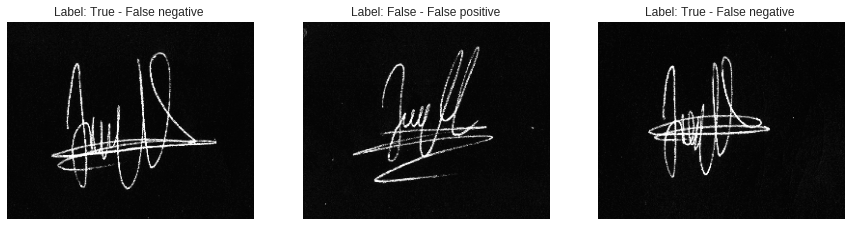

In [18]:
#@title Badly classified signatures { vertical-output: true, form-width: "53%" }
def subplot_(cantidad, col, missclassifiedList):
  if cantidad == 1:
    temp = 'False negative ' if bool(Y_test[missclassifiedList[i+col]]) else 'False positive'
    plt.imshow(img(missclassifiedList[len(missclassifiedList)-1]))
    plt.title(
        'Label: '+str(bool(Y_test[missclassifiedList[len(missclassifiedList)-1]]))+
        ' - '+temp
    )
    plt.axis('off')
  else:
    fig, axs = plt.subplots(ncols=cantidad, figsize=(15,10))
    for i in range(cantidad):  
      axs[i].imshow(img(missclassifiedList[i+col]))
      temp = 'False negative ' if bool(Y_test[missclassifiedList[i+col]]) else 'False positive'
      axs[i].set_title(
          'Label: '+str(bool(Y_test[missclassifiedList[i+col]]))+
          ' - '+temp
      )
      axs[i].set_xticks([])
      axs[i].set_yticks([])
  plt.show()
  
def img(position):
  return cv.resize(data.test_images[position], (2000, 1600))

def plotErrors(missclassifiedList):
  cantidad = missclassifiedList.shape[0]
  if cantidad == 0:
    return "There are no missclasifications"
  else:
    nrows = math.ceil(cantidad / 3)
    for i in range(nrows):
        aux = 3 if (3 * (i + 1) - cantidad < 0) else 3 - (3 * (i + 1) - cantidad)
        subplot_(aux, i, missclassifiedList)
      

plotErrors(malClasificados)

## Tensorboard



![Arquitectura](https://scontent-bog1-1.xx.fbcdn.net/v/t1.15752-9/s2048x2048/56558697_542445266246499_9105798097400758272_n.png?_nc_cat=102&_nc_ht=scontent-bog1-1.xx&oh=4e990df4db78d676b37968ad5fc963d2&oe=5D4F0064)